This Notebook presents the application of the Equivalent Layer technique using a regular-spaced grid of aerogravimetric data at Carajas, Para, Brazil. 

To achieve high efficiency in property estimative of the equivalent sources, the method CGLS for inversion was used, combined with a fast matrix-vector product only possible because of the Block-Toeplitz Toeplitz-Block(BTTB) structure of the sensitivity matrix. 

The total number of data is over 5,000,000. For this case we gridded the data to 500,00 observation points, which means that for storing the full sensitivity matrix it would be necessary 1.9 Terabytes of RAM. However, using the Toeplitz structure it is not necessary to store the whole matrix, but only the first column and first row of the first and last row of blocks of the matrix. Thus, the storage is reduced to 91 Megabytes.

### Import

In [1]:
import numpy as np
import functions as fc
import functions_fatiando as ft
from timeit import default_timer as time
from scipy.interpolate import griddata
from scipy import interpolate, signal
import pickle as pickle
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

### Observed Grid and Data

In [1]:
with open('carajas_gz.pickle', 'rb') as f:
    carajas = pickle.load(f)

NameError: name 'pickle' is not defined

In [3]:
xi = carajas['x']
yi = carajas['y']
zi = carajas['z']
dobs = carajas['gz']
shape_m = (1000, 500)
N = shape_m[0]*shape_m[1]
xi_plot = carajas['x']/1000
yi_plot = carajas['y']/1000

In [4]:
print(np.min(carajas['z']), np.mean(carajas['z']), np.max(carajas['z']))

-900.0 -900.0 -900.0


### Plot the gridded data of Carajas, Brasil

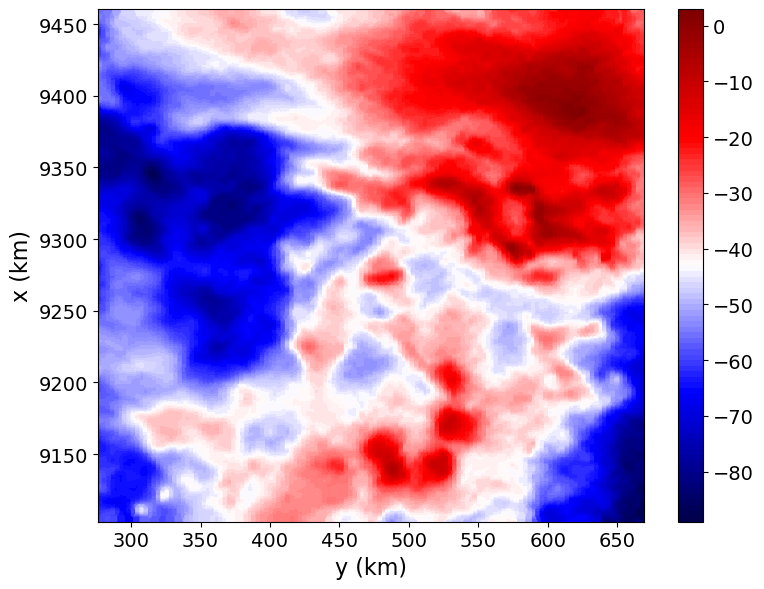

In [5]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_facecolor('xkcd:white')
#plt.tricontourf(yi_plot, xi_plot, dobs, 300, vmin=-300, vmax=300, cmap='jet')
ranges_max = np.max(dobs)
ranges_min = np.min(dobs)
plt.tricontourf(yi_plot, xi_plot, dobs, 100, cmap='seismic',vmin=ranges_min,vmax=ranges_max)
#cb = plt.colorbar(shrink=0.825)
cb = plt.colorbar()
plt.clim(ranges_min, ranges_max)
cb.ax.tick_params(labelsize=14)
#plt.axis('scaled')
#cb.set_label('$gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('x (km)', fontsize=16)
plt.tight_layout()
plt.savefig('../../../manuscript/Fig/carajas_gz_real_data_1000x500.png', dpi=300)

## Equivalent layer Depth

In [5]:
# Equivalent Layer depth
zj = np.ones_like(zi) * 300

## Convolutional equivalent layer

In [6]:
# Predicted data
s = time()
it = 50
rho_conv, gzp_conv = fc.fast_eq_bccb(xi,yi,zi,zj,shape_m,dobs,it)
e = time()
tcpu = e - s
print (tcpu)

3.6386528279981576


## Deconvolutional equivalent layer

In [7]:
# Predicted data
s = time()
mu = 10**(-22)
rho_deconv, gzp_deconv = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape_m,dobs,mu)
e = time()
tcpu = e - s
print (tcpu)

0.20715190000191797


## Data, Predicted data and Residuals plot

In [8]:
delta_conv = gzp_conv - dobs
delta_deconv = gzp_deconv - dobs

## Fast Equivalent layer BCCB plot

In [9]:
mean = np.mean(delta_conv)
print (mean)
std = np.std(delta_conv)
print (std)

0.0005096975472683027
0.15492798729938298


In [10]:
mean = np.mean(np.abs(delta_deconv))
print (mean)
std = np.std(np.abs(delta_deconv))
print (std)

0.4582999511463667
1.2295071990005288


## Transformations comparison - Upward continuation

In [11]:
z_up = np.ones_like(xi) * -3500

BTTB = fc.bttb(xi,yi,z_up,zj)
cev = fc.bccb(shape_m,N,BTTB)

gzp_conv_up = fc.fast_forward_bccb(shape_m,N,rho_conv,cev)
gzp_deconv_up = fc.fast_forward_bccb(shape_m,N,rho_deconv,cev)

In [12]:
z_up

array([-3500., -3500., -3500., ..., -3500., -3500., -3500.])

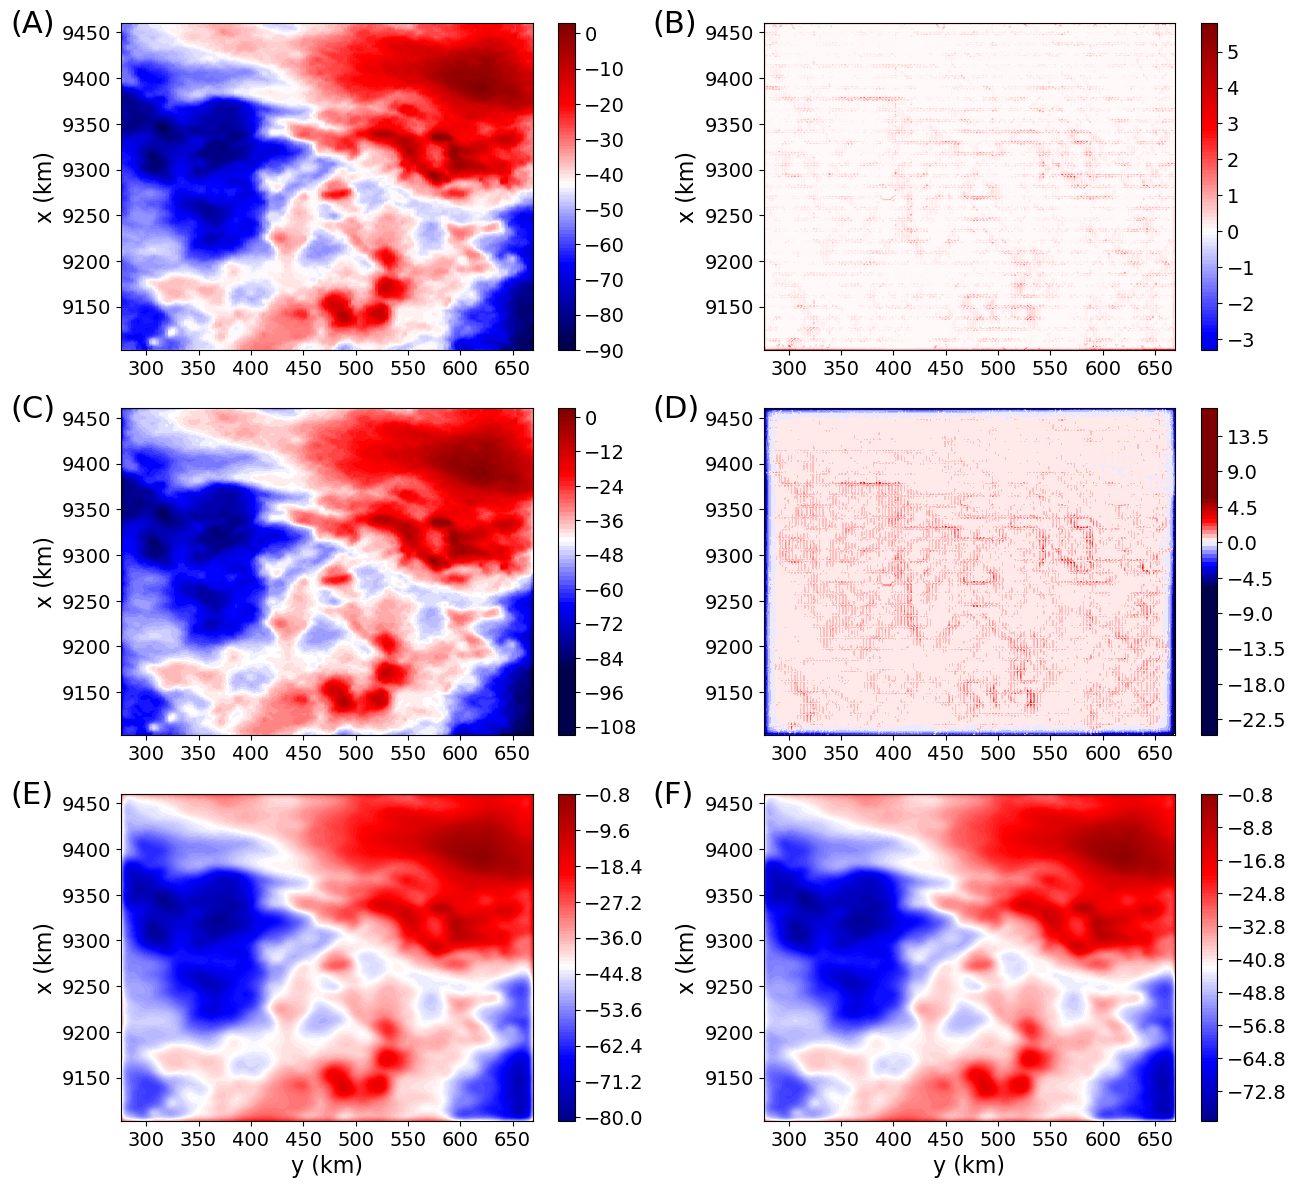

In [20]:
# plot of the total field anomaly at z=900 
fig = plt.figure(figsize=(13, 12))
fig.patch.set_facecolor('xkcd:white')

ranges_res = np.max(np.abs(delta_conv))

plt.subplot(321)
#plt.title('Convolutional method', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, gzp_conv, 100, cmap='seismic',vmin=ranges_min,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(ranges_min, ranges_max)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(A)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(322)
#plt.title('Convolutional method residual', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, delta_conv, 100, cmap='seismic',vmin=-ranges_res,vmax=ranges_res)
cb = plt.colorbar()
plt.clim(-ranges_res, ranges_res)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$residual$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(B)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(323)
#plt.title('Deconvolutional method', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, gzp_deconv, 100, cmap='seismic',vmin=ranges_min,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(ranges_min, ranges_max)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(C)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(324)
#plt.title('Deconvolutional method residual', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, delta_deconv, 100, cmap='seismic',vmin=-ranges_res,vmax=ranges_res)
cb = plt.colorbar()
plt.clim(-ranges_res, ranges_res)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$residual$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.annotate(text='(D)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(325)
#plt.title('Convolutional upward continuation', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, gzp_conv_up, 100, cmap='seismic',vmin=ranges_min,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(ranges_min, ranges_max)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(E)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.subplot(326)
#plt.title('Deconvolutional upward continuation \u03BC = $10^{-22}$', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot, gzp_deconv_up, 100, cmap='seismic',vmin=ranges_min,vmax=ranges_max)
cb = plt.colorbar()
plt.clim(ranges_min, ranges_max)
cb.ax.tick_params(labelsize=14)
#cb.set_label('$gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('x (km)', fontsize=16)
plt.annotate(text='(F)', xy=(-0.27,0.97), xycoords='axes fraction', fontsize=22)

plt.tight_layout()
plt.savefig('../../../manuscript/Fig/carajas_gz_predito_1000x500.png', dpi=300)